In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from models import DPAdaBoostClassifier

In [2]:
%matplotlib inline
np.random.seed(42)

# Setup

## Construct the Dataset

In [3]:
# Construct dataset
X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1
)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


# Two-class AdaBoost

This example fits an AdaBoosted decision stump on a non-linearly separable
classification dataset composed of two "Gaussian quantiles" clusters
(see :func:`sklearn.datasets.make_gaussian_quantiles`) and plots the decision
boundary and decision scores. The distributions of decision scores are shown
separately for samples of class A and B. The predicted class label for each
sample is determined by the sign of the decision score. Samples with decision
scores greater than zero are classified as B, and are otherwise classified
as A. The magnitude of a decision score determines the degree of likeness with
the predicted class label. Additionally, a new dataset could be constructed
containing a desired purity of class B, for example, by only selecting samples
with a decision score above some value.


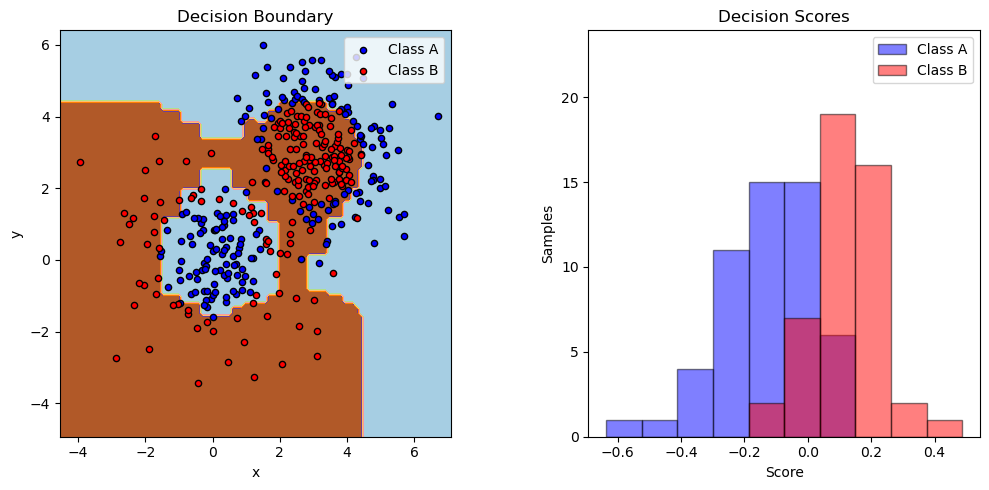

In [5]:
# Author: Noel Dawe <noel.dawe@gmail.com>
# Oriignal Source link: https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py
# License: BSD 3 clause

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), algorithm="SAMME",
    n_estimators=200, random_state=42
)

bdt.fit(X_train, y_train)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
ax = plt.subplot(121)
disp = DecisionBoundaryDisplay.from_estimator(
    bdt,
    X_test,
    cmap=plt.cm.Paired,
    response_method="predict",
    ax=ax,
    xlabel="x",
    ylabel="y",
)
x_min, x_max = disp.xx0.min(), disp.xx0.max()
y_min, y_max = disp.xx1.min(), disp.xx1.max()
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y_train == i)
    plt.scatter(
        X_train[idx, 0],
        X_train[idx, 1],
        c=c,
        cmap=plt.cm.Paired,
        s=20,
        edgecolor="k",
        label="Class %s" % n,
    )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc="upper right")

plt.title("Decision Boundary")

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X_test)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(
        twoclass_output[y_test == i],
        bins=10,
        range=plot_range,
        facecolor=c,
        label="Class %s" % n,
        alpha=0.5,
        edgecolor="k",
    )
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.xlabel("Score")
plt.title("Decision Scores")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

# DEMO: *Differentially-Private* Two-class AdaBoost

In [41]:
# Define the parameters for the algorithm
epsilon = 0.1
delta = 0.01
T = 200
D = np.ones(len(X)) / len(X)  # Initialize the weights to be uniform

# Create an array to hold the outputs of each weak classifier
h = np.zeros((len(X), T))

for t in range(T):
    # Rescale the weights to sum to 1
    D = D / np.sum(D)

    # Create a decision tree classifier with a maximum depth of 1
    tree = DecisionTreeClassifier(max_depth=1, random_state=42)

    # Train the decision tree classifier using the weighted data
    tree.fit(X, y, sample_weight=D)

    # Compute the predictions of the decision tree classifier
    h[:, t] = tree.predict(X)

    # Compute the error of the decision tree classifier
    err = np.sum(D * (h[:, t] != y))

    # Compute the weight of the weak classifier
    alpha = np.log((1 - err) / err) / 2

    # Update the weights of the training examples
    D = D * np.exp(-alpha * y * h[:, t])
    D = D / np.sum(D)

# Compute the predictions of the boosted classifier
predictions = np.sign(np.sum(h, axis=1))

# Add Laplace noise to the predictions to achieve differential privacy
scale = 2 * len(X) / epsilon
noise = np.random.normal(scale=scale, size=len(X))
private_predictions = np.sign(np.sum(h, axis=1) + noise)

# Create an AdaBoost classifier with the same parameters as the boosted classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                         n_estimators=T, random_state=42)

# Train the AdaBoost classifier using the non-private predictions
clf.fit(X, predictions)

# Create a differentially private AdaBoost classifier
dp_clf = DPAdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    tau=0.5,
    k=0.89365908543,  # used to set n_estimators ~200
    random_state=42,
    epsilon=epsilon,
    delta=delta
)

# Train the differentially private AdaBoost classifier using the private predictions
dp_clf.fit(X, private_predictions)

# Evaluate the classifiers
base_score = clf.score(X_test, y_test)
dp_score = dp_clf.score(X_test, y_test)

print("Non-private score: {:.2f}%".format(base_score * 100))
print("Differentially private score: {:.2f}%".format(dp_score * 100))

T: 200
weight shape: ()
Non-private score: 58.00%
Differentially private score: 45.00%


/Applications/anaconda3/envs/559/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Applications/anaconda3/envs/559/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:506: UserWarning: Sample weights have reached infinite values, at iteration 0, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)


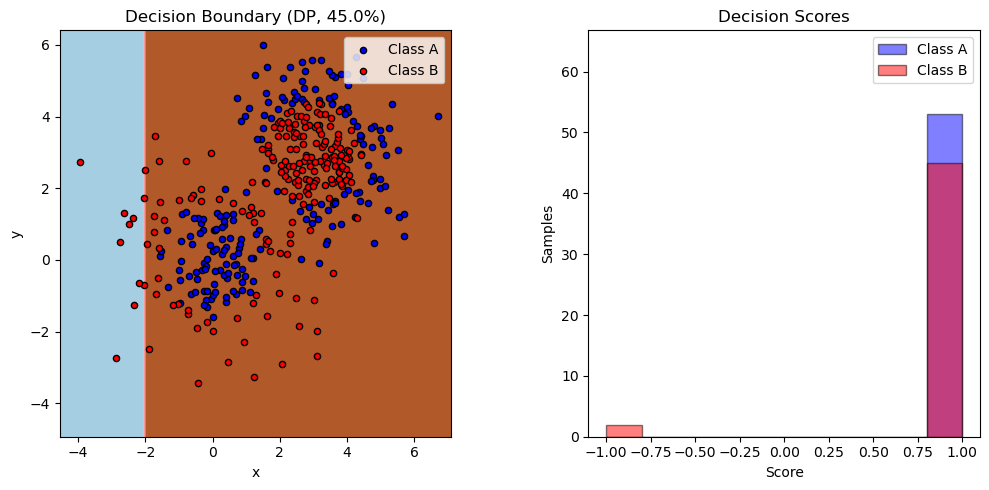

In [42]:
plt.figure(figsize=(10, 5))

# Plot the decision boundaries
ax = plt.subplot(121)
disp = DecisionBoundaryDisplay.from_estimator(
    dp_clf,
    X_test,
    cmap=plt.cm.Paired,
    response_method="predict",
    ax=ax,
    xlabel="x",
    ylabel="y",
)
x_min, x_max = disp.xx0.min(), disp.xx0.max()
y_min, y_max = disp.xx1.min(), disp.xx1.max()
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y_train == i)
    plt.scatter(
        X_train[idx, 0],
        X_train[idx, 1],
        c=c,
        cmap=plt.cm.Paired,
        s=20,
        edgecolor="k",
        label="Class %s" % n,
    )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc="upper right")

plt.title(f"Decision Boundary (DP, {dp_score * 100}%)")

# Plot the two-class decision scores
twoclass_output = dp_clf.decision_function(X_test)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(
        twoclass_output[y_test == i],
        bins=10,
        range=plot_range,
        facecolor=c,
        label="Class %s" % n,
        alpha=0.5,
        edgecolor="k",
    )
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.xlabel(f"Score")
plt.title("Decision Scores")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

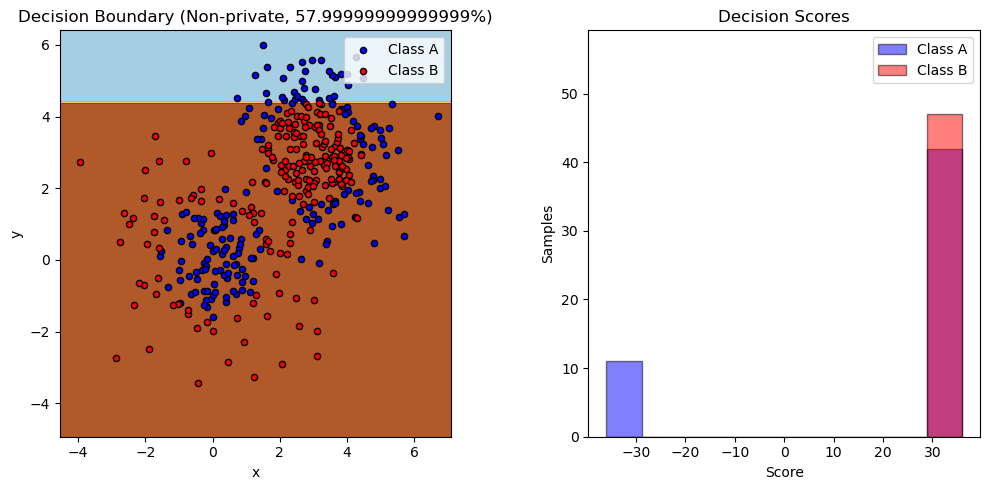

In [43]:
plt.figure(figsize=(10, 5))

# Plot the decision boundaries
ax = plt.subplot(121)
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_test,
    cmap=plt.cm.Paired,
    response_method="predict",
    ax=ax,
    xlabel="x",
    ylabel="y",
)
x_min, x_max = disp.xx0.min(), disp.xx0.max()
y_min, y_max = disp.xx1.min(), disp.xx1.max()
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y_train == i)
    plt.scatter(
        X_train[idx, 0],
        X_train[idx, 1],
        c=c,
        cmap=plt.cm.Paired,
        s=20,
        edgecolor="k",
        label="Class %s" % n,
    )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc="upper right")

plt.title(f"Decision Boundary (Non-private, {base_score * 100}%)")

# Plot the two-class decision scores
twoclass_output = clf.decision_function(X_test)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(
        twoclass_output[y_test == i],
        bins=10,
        range=plot_range,
        facecolor=c,
        label="Class %s" % n,
        alpha=0.5,
        edgecolor="k",
    )
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.xlabel(f"Score")
plt.title("Decision Scores")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()